# Using Machine Learning to Predict Whether a Game is a Win or a Loss in League of Legends

Hello! In this notebook we will acquire player data from Riot's API. This includes data from the player's last 100 matches. The data we are interested in for the purposes of this notebook are the kills, deaths assists and gold earned by that player for each game. We use machine learning to build a logistic regression model that predicts whether that game is a win or a loss.

You can easily edit this notebook to analyze your own data. GLHF!

In [1]:
import riotwatcher
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

%matplotlib inline

## Retrieving User Data from Riot API Using Riotwatcher

We can use the Python package riotwatcher (https://github.com/pseudonym117/Riot-Watcher) to utilize Riot's API (https://developer.riotgames.com/)and get relevant data of a player and their matches.

We create an instance of LolWatcher, which is an interface between Python and Riot's API, where we can call various methods to look at data from Riot's API. To do this we need an api_key from Riot games. You can do this by going on the Riot API website provided in the cell above. The API key is what let's riot know who is accessing their data. API keys should not be shared with anyone. If you are going to use riotwatcher code (or some version of this code) for anything, make sure you edit out your API key.

In [2]:
watcher = riotwatcher.LolWatcher(api_key = '')

Let's use riotwatcher to get identifying information on Doublelift

## Weird Caveats to summoners

I tried grabbing data for Doublelift and found that the data i grabbed did not match up with that of OP.gg or U.gg.

The last match that they have is from 3 days ago. I believe that they are not able to grab data as frequently as I expected, at least for the day I tried for whatever reason. I have no idea why this is the case.

Knowing this, we will only compare data acquired from non-famous users to sites like OP.gg and U.gg because they usually matched up from my experience. This will be done outside this notebook and I encourage you to cross-validate your data from these sites as well (as well as directly from Riot's API).

In [3]:
#We will grab username of the player of interest
summoner_name = 'puddingpiler'

#We can use the LolWatcher instance to get some data on the user's identifying information
watcher.summoner.by_name(region = 'na1', summoner_name = summoner_name)

{'id': '1-lKe0sKHoomm1cGKTMGm3usHkmg0g-WD420VYOlLW_MS1I',
 'accountId': 'TLGnXMAPXufbdp4-QHxRNZH4YxgyOh3bvVyr0KEs8ao2-Ac',
 'puuid': 'IhFJhHpKEN_vNez9P-N98_45C83HsUxDdyTAWrJYaoDdCt4SN0TPxeQ96rar0hT9njemIRezJ2gQrQ',
 'name': 'puddingpiler',
 'profileIconId': 4052,
 'revisionDate': 1647387185000,
 'summonerLevel': 414}

## Data Retrieval

We will now use riotwatcher to retrieve data from Riot Games. The data we will be retrieving here is data from the past 100 matches of the player Doublelift. Riotwatcher can only download 100 games per one call of watcher.match.matchlist_by_puuid, so that is the amount of games that we will analyze.

In [4]:
#Getting the puuid, a string identifying a player
my_puuid = watcher.summoner.by_name('na1', summoner_name)['puuid']

#How many matches do you want the data from (max is 100 for LolWatcher)
count = 100


#Grab list of {count} last match id's
match_list = watcher.match.matchlist_by_puuid(region = 'americas', puuid = my_puuid, count = count)


#We will append various data from the matches onto these empty lists
match_id = []
kills = []
deaths = []
assists = []
gold_total = []
queue_id = []
win = []

dir_path_name = 'Riot_API_Folder'


#Creating a folder that will contain data files from Riot's API
if os.path.isdir(dir_path_name) is False:
    os.mkdir(dir_path_name)


#Loop over all these matches 
for match in match_list:
    
    #We want to append the match identifier string
    match_id.append(match)
    
        
    #Grabs dictionary of match info from Riot API
    match_json = watcher.match.by_id('americas', match)
    
    
    #Grabs the part of the dictionary that contains non-metadata
    match_details = watcher.match.by_id('americas', match)['info']
    
    
    #Saving the match details to a json file for future use
    with open("{}/{}_match_details_{}.json".format(dir_path_name, summoner_name, match), "w") as outfile:
        json.dump(match_json, outfile)

    
    #Identify the player of interest in each match
    #Since there are 10 players we need a way to identify the data of the player of interest
    #I do this by looping through the players' puuid and picking the one that matches the
    #puuid of the player of interest
    for player in match_details['participants']:

        if player['puuid'] == my_puuid:
            
            #These are the metrics that we are interested in
            #There are many metrics provided by Riot's API, and in future projects
            #I will be more comprehensive with the features I choose
            kills.append(player['kills'])
            deaths.append(player['deaths'])
            assists.append(player['assists'])
            gold_total.append(player['goldEarned'])
            queue_id.append(match_details['queueId'])
            win.append(player['win'])

        else: pass


## Importing Data From JSON Files

# NOTE:

## Only run next cell of code if you have downloaded relevant JSON files from cell above

I have downloaded the json files from Riot's API from the relevant code above so we can use it later. This cell above takes a little while to run and saving data in its completeness ensures I can go back and do any kind of analysis swiftly.

In the code cell above we created lists of relevant player data. However, we may want to do some extra analysis on this data and may not want to rerun this cell above. This code cell below walks us through how to create the same lists as the code cell above. Skip this cell if you are creating the lists from the cell above.

In [6]:
#Getting the filenames in the folder containing match json files

#NOTE: if there are any other files in here OR there are duplicate files, you need to do some cleaning 
#in that directory
filenames = [name for name in os.listdir(dir_path_name)]


#Getting the number of files in the folder containing match json files. 
file_counts = len(filenames)



match_id = []
time_begin = []
kills = []
deaths = []
assists = []
gold_total = []
queue_id = []
win = []


for i in range(file_counts):
    
    #Loading the match data from the json file we created in the code cell above
    match_json = json.load(open(dir_path_name+'/'+filenames[i]))
    
    
    #Getting the match id from this file
    match_id.append(match_json['metadata']['matchId'])    
    
    
    #Getting the timestamp for when the match began. Units are in Unix time.
    time_begin.append(match_json['info']['gameStartTimestamp'])
    
    
    #Getting the queue ID for the match
    queue_id.append(match_json['info']['queueId'])
    
    
    
    for player in match_json['info']['participants']:
        
        if player['puuid'] == my_puuid:
            
            kills.append(player['kills'])
            deaths.append(player['deaths'])
            assists.append(player['assists'])
            gold_total.append(player['goldEarned'])
            win.append(player['win'])
            
    
            
            #Used for testing if you get the same data from other sources (Like OP.gg or U.gg)
            '''print(match_json['info']['participants'][0]['kills'],
                  match_json['info']['participants'][0]['deaths'],
                  match_json['info']['participants'][0]['assists'])'''
            
            
        else: pass

## Cleaning Data

Riot's API identifies a game type such as Ranked Solo/Duo, ARAM, Draft through identifying numbers called queue_id.The relevant ones for the data I'll be using are:
- 400 -> Draft Pick
- 420 -> Ranked Solo/Duo
- 450 -> ARAM
- 900 -> ARURF

However, Riot has an exhaustive list of all available queue ID's found here (https://static.developer.riotgames.com/docs/lol/queues.json). You can write a few lines of code that gets the queue type from the queue id that utilizes this json file, if you wish.

In [7]:
#We will create a new list that replaces these nubmers with string of match type
match_type = []

for queue in queue_id:
    
    if queue == 420:
        match_type.append('Ranked')
    
    elif queue == 450:
        match_type.append('ARAM')
        
    elif queue == 400:
        match_type.append('Draft')
        
    elif queue == 900:
        match_type.append('ARURF')
        
    else:
        match_type.append(queue)

## Creating the Pandas dataframe

In [8]:
#Joining together all data acquired through LolWatcher
df = pd.DataFrame({'match_id': match_id, 
                   'timeStart': time_begin,
                   'kills': kills, 
                   'deaths': deaths, 
                   'assists': assists, 
                   'gold_earned': gold_total,
                   'match_type': match_type,
                   'win': win
                  })


#Let's sort this data by time. Most recent games come at the top of the dataframe
df.sort_values(by = ['timeStart'], inplace = True, ascending = False)

In [9]:
df.head(10)

match_id      timeStart  kills  deaths  assists  gold_earned  \
65  NA1_4249485376  1647533810412     21       5       15        20301   
22  NA1_4249502047  1647531633597     15       4       13        14487   
74  NA1_4249057515  1647488447367     19       6       13        20866   
67  NA1_4249009046  1647486442690     13       1        3        13729   
6   NA1_4247862756  1647386203343     28       6       17        16335   
36  NA1_4247851698  1647385270322      7       6       12         8803   
90  NA1_4247817907  1647383843857     13       8       19        17251   
37  NA1_4247796220  1647382299797     14       9       34        15190   
17  NA1_4246889034  1647287335251     11      10       14        15482   
93  NA1_4246887442  1647286178709      4       7       23         9363   

   match_type    win  
65      Draft   True  
22      Draft   True  
74      Draft   True  
67      Draft   True  
6        ARAM   True  
36       ARAM  False  
90       ARAM  False  
37       ARAM   True  
17       ARAM   True  
93       ARAM   True

## More Cleaning

In [10]:
#Replacing the win column of booleans with 1 or 0 instead of the True/False values given
#1 indacates a win and 0 indicates loss
df['win'] = df['win'].apply(lambda x: 1 if x == True else 0)

## Separating Game Modes

We want to separate all the different game modes from each other (ARAM, Ranked, etc.) so that we may do data analysis on data from one game type at a time.

In [11]:
#Getting a count of what kind and how many matches there are
df['match_type'].value_counts()

ARAM      71
Draft     17
ARURF     10
Ranked     2
Name: match_type, dtype: int64

In [12]:
#Creating dataframes of gametypes
#Dropping the match_type columns since it will be redundant with the name of the dataframe

ARAM = df[df['match_type'] == 'ARAM'].drop(['match_type'], axis = 1)
Draft = df[df['match_type'] == 'Draft'].drop(['match_type'], axis = 1)
ARURF = df[df['match_type'] == 'ARURF'].drop(['match_type'], axis = 1)
Ranked = df[df['match_type'] == 'Ranked'].drop(['match_type'], axis = 1)


#Checking if data separated correctly
print ('ARAM:', len(ARAM), 'Draft:', len(Draft), 'ARURF:', len(ARURF), 'Ranked:', len(Ranked))

ARAM: 71 Draft: 17 ARURF: 10 Ranked: 2


## Checking Out Dataframe of One Game Type

In [13]:
ARAM.head()

match_id      timeStart  kills  deaths  assists  gold_earned  win
6   NA1_4247862756  1647386203343     28       6       17        16335    1
36  NA1_4247851698  1647385270322      7       6       12         8803    0
90  NA1_4247817907  1647383843857     13       8       19        17251    0
37  NA1_4247796220  1647382299797     14       9       34        15190    1
17  NA1_4246889034  1647287335251     11      10       14        15482    1

## Predicting Wins using a Logistic Regression Model

We now want to answer the questions: 
- Can we predict if a player will win based on user metrics, such as kills, deaths, etc.?
- What independent variables are good predictors for a win or lose?

We can start answering these questions by using a logistic regression model to predict whether or not a player wins or loses where the independent variables are some of those given in the dataframe created earlier.

If we find that these independent variables are not good predictors, then we can always go back and insert new types of variables from match data into our logistic regression model as an extension of this project. This is why we save the data to file. If we wish to improve on our model with new variables, we don't have to go back to getting the data from Riot as this make take some time.

## Building a Logistic Regression Model

To build any machine learning model, we must divide our avaiable data into three datasets:
- training dataset : Used to train the model to predict outcomes
- testing dataset : Data used to test the model created through the training dataset. We can then tweak the model until we have reasonable predictions
- validation dataset : Final testing dataset for the model. If the model does not predict well enough, then we start over with our model. Either toss the model, or review if you made enough reasonable changes to your model in the first place in the testing phase.

We will not be validating this dataset as I believe there is not enough data with 100 points. It is actually quite easy to get more data from games past 100, I believe you just have to include a timestamp in watcher.match.matchlist_by_puuid() that excludes games after that timestamp.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Training the Model

I have mostly played ARAM so we will use that data for the rest of this notebook. It is probably more fun to analyze ranked data, so all you need to do is change the ARAM dataframe to the Ranked one and you're good to go.

In [15]:
#X are the independent variables that will be used to predict a win or loss
X = ARAM[['kills', 'deaths', 'assists', 'gold_earned']]

#y is the dependent variable/outcome. It is given by a 1 for a win or a 0 for a loss
y = ARAM['win']

#We will split our dataframe to train and test our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
#Creating an Instance of the Logistic regression model form scikit-learn
LogModel = LogisticRegression()

In [17]:
#Fitting the training data onto our logistic regression model
LogModel.fit(X_train, y_train)

LogisticRegression()

### Testing the Model

In [18]:
#Predicting from our test data whether we win or lose a game
y_predict = LogModel.predict(X_test)

## Analyzing Model Predictions

We can analyze the model predictions a few different ways. Here we will be doing 3 different analyses of our results described below. 

### Bar Plot

(Analysis 1) bar plot where 0 and 1 represent correct and incorrect predictions, respectively of a win or loss.

In [19]:
#Using Cufflinks/Plotly to create this plot
import cufflinks as cf

cf.go_offline()

In [20]:
np.abs((y_predict - y_test)).iplot(kind = 'histogram', 
                                   xTitle = '0: Correct Predictions | 1: Incorrect Predictions',
                                   yTitle = 'Count')


Text(0.5, 0, '0: Correct Predictions | 1: Incorrect Predictions')

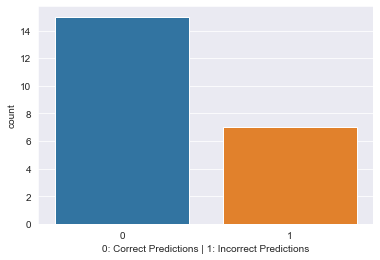

In [21]:
#If Cufflinks doesn't work then try this
sns.set_style('darkgrid')
sns.countplot(x = np.abs(y_predict - y_test))
    
plt.xlabel('0: Correct Predictions | 1: Incorrect Predictions')

### Confusion Matrix

Here we create a confusion matrix identifying True Positives, False Positives, False Negatives, True Negatives

In [22]:
from sklearn.metrics import confusion_matrix

#Confusion matrix giving:
#    True Negative    False Positive
#    False Negative   True Positive
confusion_matrix(y_test, y_predict)

array([[7, 2],
       [5, 8]])

### Classification Report

Here we identify different metrics for the results of our model including Precision, Recall and F1 Score. We can think of these metrics as follows:

- Precision : Number of true positives  / number of all positives predicted i.e. TP/(TP+FP)
- Recall : Number of true positives / number of all positives i.e. TP/(TP+FN)
- F1 Score : Harmonic Mean of Precison and Recall i.e. 2*Precision*Recall/(Precision+Recall)

In [23]:
from sklearn.metrics import classification_report

classification_report(y_test, y_predict,
                        output_dict=True
                     )['1']

{'precision': 0.8,
 'recall': 0.6153846153846154,
 'f1-score': 0.6956521739130435,
 'support': 13}

## Results

We were able to train our logistic regression model with data from 49 matches and tested our model on 22 matches. We were able to correctly predict ~68% of match outcomes and incorrectly predicted ~32% of match outcomes.

Of these correctly predicted matches, our model predicted 8 true wins and 7 true losses. There were 2 false wins (predicted a win when in fact it was a loss) and 5 false losses (predicted a loss when in fact it was a win).

- Precision : We got a precision score of 0.8, meaning that there weren't that many false wins as compared to true wins, which is good.

- Recall : We got a recall score of ~0.62, meaning there were almost an equal number of correctly reported wins to the number of incorrectly reported wins. This is not good.

- F1 Score : We got an F1 score of ~.69. It is hard to say whether an F1 score is good or bad. What we can do is keep tuning our model and if the F1 Score increases, then, generally, we will prefer that model.

## Conclusion

We acquired player data from Riot's API, cleaned it and separated it by game type. We then used machine learning to train a logistic regression model to predict whether a game is a win or a loss depending on player metrics. We found that our model's accuracy is about 68% with an F1 Score of about 0.7. When trying to improve this model we must attempt to increase all relevant metrics (Accuracy, Precision, Recall and F1 Score) in order to say that we have a good model for predicting match outcomes.

The next steps for this project is to increase the amount of player metrics tha we use for this model. These may include:

- Metrics of teammates or opponents : If you team is doing good/bad, you are probably more likely to win/lose. If the enemy team is doing good/bad you are probably more likely to lose/win.

- Differential metrics : Differences in gold between each team is probably a good predictor for a win or lose.

- Players' Champion Frequency : If a player has only played a certain champion once or twice, they may not do so well.

There are so many predictors that we can think of, but choosing the most relevant ones to keep the number of independent variables as small as possible is important in prediction. This requires a lot of fiddling with the model until we get the best prediction/independent variables.